# Stacking ensemble

## 1. 이 모델을 사용해야 하는 이유

### 1. model의 장점은 overfitting을 감소시키는 효과가 있다.

- 1. 데이터를 sub_model에 넣어 예측 결과를 생성한다.

- 2. 예측결과를 데이터로 사용하여 다른 모델을 생성한다.

- 3. 원래 있던 데이터와는 다른 데이터를 사용하므로 예측결과의 overfitting과 bias가 줄어들게 된다.

### 2. model에 따라서 가중치를 줌으로 기여도에 따라서 다른 값을 낸다.

- 즉, 가중치에 따라서 결과값이 좋아질 수도 나빠질 수도 있다.

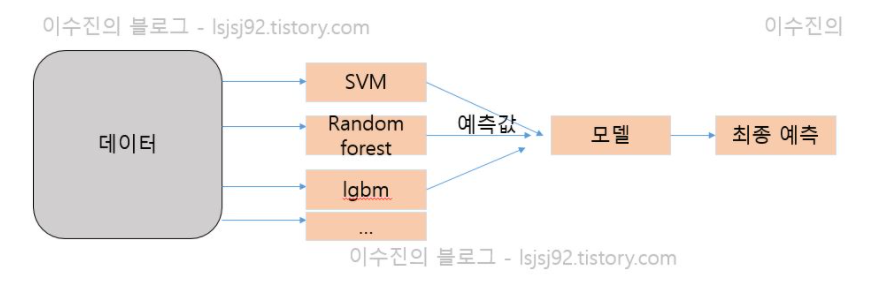

## Combination sub-models

- 각 sub-model의 결과를 결합하는 meta learner 모델은 simple linear model을 사용하는 것이 일반적이다.
- 또는 sub-model을 neural network으로 생성하고 meta learner를 big neural network model로 설정하여 sub-model을 embedding 시키는 방법도 있다.

## Combination predictions

- regression의 경우 각 sub-model의 값이 그대로 meta-learner의 input 값으로 들어가게 된다.
- classification경우라도 각 sub-model의 예측 결과는 label 보다는 label probabilities를 input 값으로 넣는다. 이 것이 더 좋은 결과를 생성한다.

## 코드로 쉽게 알아보기

In [ ]:
models=[LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),CatBoostRegressor()]
final_model = XGBRegressor()
def stacking_ensemble(models, data = None, target = None, test_size = 0.2,
                      n_folds = 5, final_model = final_model):
    # kfold를 사용한다.
    kfold = KFold(n_splits = n_folds)
    
    # 데이터를 train데이터와 test 데이터로 나누어준다.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = test_size, random_state = 100)
    
    # 각 모델의 평균값을 넣어주기 위해서 공간을 만든다.
    final_train_predict = np.zeros((X_train.shape[0], len(models)))
    final_test_predict = np.zeros((X_test.shape[0], len(models)))
    
    for model_count, model in enumerate(models):
        
        # 각 모델마다 k_fold의 값들을 넣어주기 위해서 공간을 만든다.
        test_predict = np.zeros((X_test.shape[0], n_folds))
        
        # X_train의 데이터를 train과 valid로 나누기 
        for fold_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
            X_train_n = X_train.iloc[train_idx]
            y_train_n = y_train.iloc[train_idx]
            X_test_n = X_train.iloc[valid_idx]
        
            # 개별 모델을 학습한다.
            model = model.fit(X_train_n, y_train_n)
            final_train_predict[valid_idx, model_count] = model.predict(X_test_n)
            test_predict[:, fold_count] = model.predict(X_test)
            
        # 교차검증을 한 데이터를 가지고 평균 구하기    
        final_test_predict[:,model_count] = np.mean(test_predict, axis = 1)
                
    # 최종 모델로 학습시키기
    final_model = final_model.fit(final_train_predict, y_train)
    y_pred = final_model.predict(final_test_predict)
    
    # RMSE값 반환하기
    test_rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(test_rmse)

- 이건 cv stacking ensemble을 활용한 것이다.
- 각 모델의 train 검증값들로 이루어진 값들을 meta model을 이용하여 돌리는 것
- 각 모델의 train의 검증값을 돌린 모델을 test 전체 모델에 수행해주고 그것을 각 모델별 평균을 구한 이후
- meta model을 돌려서 결과값을 낸다.